In [77]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


import pandas as pd
import numpy as np
import warnings
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.layers import LSTM

In [2]:
# suppressing warning messages

warnings.filterwarnings('ignore')

In [3]:
sys.path.insert(1, '../scripts')

from data_viz import Data_Viz
from data_cleaning import DataCleaner
from data_transformation import DataTransformer

DV = Data_Viz("../logs/deep_model_notebook.log")
DC = DataCleaner("../logs/deep_model_notebook.log")
DT = DataTransformer("../logs/deep_model_notebook.log")

In [4]:
# importing the data

train = pd.read_csv("../data/train_store.csv")

In [58]:
# checking available variables
train = train.sort_values(by="Date")
train["Date"] = pd.to_datetime(train["Date"])

print("rows and columsn: ", train.shape)
DV.summ_columns(train)

rows and columsn:  (1017209, 24)


,variables,missing_count,missing_percent_(%),data_type,unique_values
0,Store,0,0.0,int64,1115
1,DayOfWeek,0,0.0,int64,7
2,Date,0,0.0,datetime64[ns],942
3,Sales,0,0.0,float64,13194
4,Customers,0,0.0,float64,1423
5,Open,0,0.0,int64,2
6,Promo,0,0.0,int64,2
7,StateHoliday,0,0.0,object,4
8,SchoolHoliday,0,0.0,int64,2
9,StoreType,0,0.0,object,4


In [59]:
# Sales per Day

tsa_df_days = train[["Date", "Sales"]].groupby(["Date"]).agg({"Sales":"mean"})

print("rows and columns: ", tsa_df_days.shape)
print(DV.summ_columns(tsa_df_days))
tsa_df_days.head()

rows and columns:  (942, 1)
  variables  missing_count  missing_percent_(%) data_type  unique_values
0     Sales              0                  0.0   float64            942


,Sales
Date,
2013-01-01,76.857271
2013-01-02,6050.476233
2013-01-03,5577.322870
2013-01-04,5832.756054
2013-01-05,5178.539910


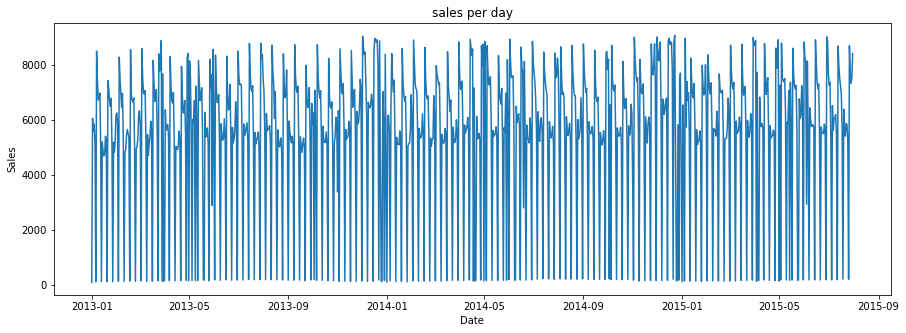

In [60]:
DV.plot_line(tsa_df_days, "Date", "Sales", [15, 5], "sales per day", "sales_day.png")

In [61]:
# creating week based data
tsa_df_weeks = train[["WeekOfYear", "Sales"]].groupby(["WeekOfYear"]).agg({"Sales": "mean"})
print("rows and columns: ", tsa_df_weeks.shape)
print(DV.summ_columns(tsa_df_weeks))
tsa_df_weeks.head()

rows and columns:  (52, 1)
  variables  missing_count  missing_percent_(%) data_type  unique_values
0     Sales              0                  0.0   float64             52


,Sales
WeekOfYear,
1,4178.906935
2,5971.973479
3,4972.792099
4,5400.159983
5,5288.572283


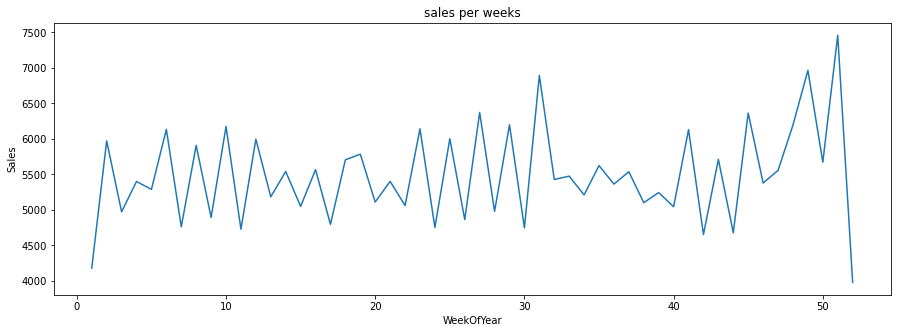

In [62]:
DV.plot_line(tsa_df_weeks, "WeekOfYear", "Sales", [15, 5], "sales per weeks", "sales_weeks.png")

**Observation**
- The data seems like it has somewhat constant mean and SD.
- There doesn't seem to be any seasonality as well.
- as a result it is probably a stationary data
- but let's verify that

## Checking for Stationarity

In [73]:
# using variance and mean
def check_stationary_mv(df, title):
    print("\n", title)
    X = df[1:].values
    split = round(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1= %f, mean2= %f' % (mean1, mean2))
    print('variance1= %f, variance2= %f' % (var1, var2))

check_stationary_mv(tsa_df_days, "sales per days")
check_stationary_mv(tsa_df_weeks, "sales per weeks")


 sales per days
mean1= 5388.312197, mean2= 5577.778527
variance1= 6455921.670277, variance2= 7309082.871455

 sales per weeks
mean1= 5444.767792, mean2= 5583.461418
variance1= 266506.012053, variance2= 602656.074505


In [71]:
# using The Augmented Dickey-Fuller test
# the null hypothesis is that the series is non-stationary
# if p-value is < 0.05 we will reject the null hypothesis

def check_stationary(df, col, title):
    print("\n",title )
    adfResult = adfuller(df[col].values, autolag='AIC')
    print(f'ADF Statistic: {adfResult[0]}')
    print(f'p-value: {adfResult[1]}')
    return adfResult

check_stationary(tsa_df_days, "Sales", "sales per day")
check_stationary(tsa_df_weeks, "Sales", "sales per weeks")
print("")


 sales per day
ADF Statistic: -6.0051603932928135
p-value: 1.62206616261918e-07

 sales per weeks
ADF Statistic: -3.7189190627235535
p-value: 0.003854774891383453



**Observation**
- the dataset is stationary because ADF is big negative and p-value is below 0.005

## checking autocorrelation

In [74]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Sales")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

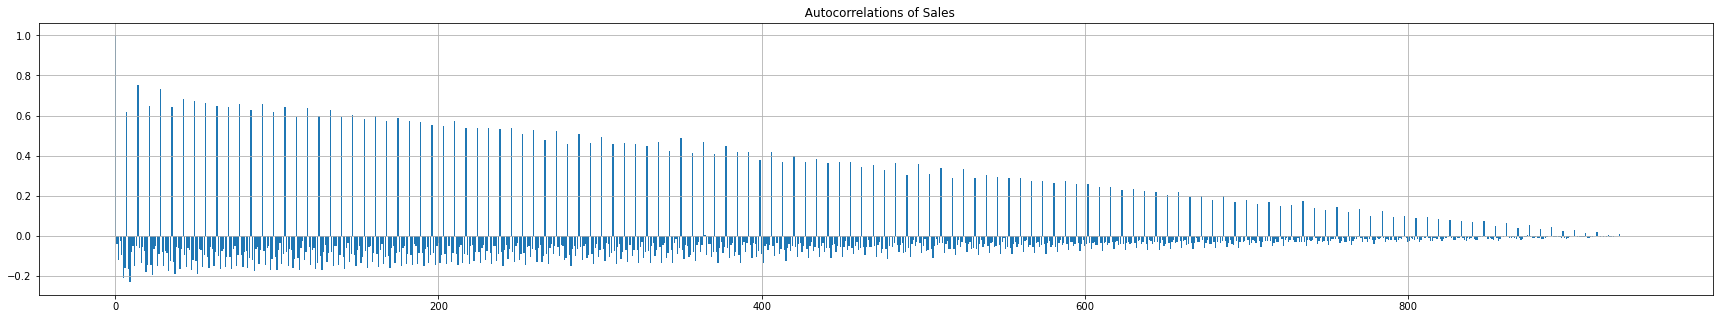

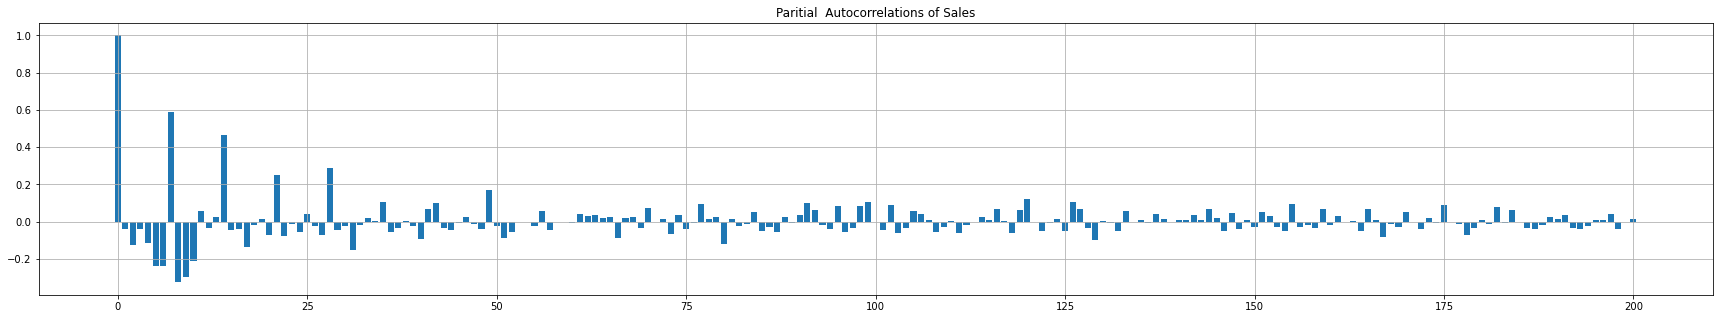

In [84]:
# plotting autocorrelation graph for sales per day
acf_days = acf(tsa_df_days.Sales.values, fft=True, nlags=941)
acfNp = np.array(acf_days)
pacf_days = pacf(tsa_df_days.Sales.values, nlags=200)
pacfNp = np.array(pacf_days)

corrPlots(acfNp, '')
corrPlots(pacfNp, "Paritial")

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

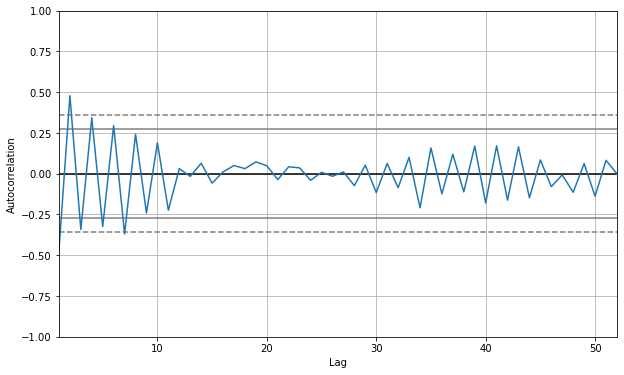

In [42]:
# plotting autocorrelation graph for sales per weeks
plt.rc("figure", figsize=(10,6))
pd.plotting.autocorrelation_plot(tsa_df_weeks['Sales'])

# scaling the data

In [85]:
# scaling the data from -1 go 1
scaler = MinMaxScaler()
scaler.fit(tsa_df_days.Sales.values.reshape([-1, 1]))
SalesScaled = scaler.transform(tsa_df_days.Sales.values.reshape(-1, 1))
tsa_df_days['SalesScaled'] = SalesScaled
tsa_df_days.tail(10)

,Sales,SalesScaled
Date,,
2015-07-22,5402.158744,0.592287
2015-07-23,5870.411659,0.644366
2015-07-24,5815.365022,0.638244
2015-07-25,5284.921973,0.579248
2015-07-26,191.102242,0.012706
2015-07-27,8694.100448,0.958421
2015-07-28,7742.983857,0.852636
2015-07-29,7326.593722,0.806325
2015-07-30,7510.558744,0.826786


## Training and Validation set separation

In [87]:
SIZE = len(tsa_df_days.SalesScaled)
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [88]:
DateTrain = tsa_df_days.index.values[0:BATCH_SIZE]
DateValid = tsa_df_days.index.values[BATCH_SIZE:]
XTrain = tsa_df_days.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = tsa_df_days.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [ ]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

In [ ]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

In [ ]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [ ]:
# Example of Window
datasetEx = tf.data.Dataset.from_tensor_slices(tf.range(10))
datasetEx = datasetEx.window(5, shift=1, drop_remainder=True)
for window in datasetEx:
    print([elem.numpy() for elem in window])

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [ ]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

In [ ]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [ ]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [ ]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [ ]:
model.summary()

In [ ]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

## Assess Accuracy of Forecast

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
Forecast = model_forecast(model, houseSales.HouseSalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

In [ ]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [ ]:
print(textstr)